## Import Libs

In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import sys
import warnings
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
import joblib

### Import Dataset

In [11]:
import os

# Construct the absolute file path
file_path = '../dataset/Product_Explanation.txt'
# Initialize lists to store the parsed data
product_ids = []
descriptions = []

with open(file_path, 'r') as file:
    for line in file:  # Adjust the range to read more lines if needed
        #print(line)
        product_id, description = line.strip().split(';', 1)
        #print(product_id ,"+", description)
        product_ids.append(product_id)
        descriptions.append(description)
print(len(product_ids))
# Open and read the file

1800


In [72]:
file_path = '../dataset/Product_Categories.txt'

# Initialize lists to store the parsed data
categories = []
turkish_lower_mapping = str.maketrans('İI', 'ii')

with open(file_path, 'r') as file:
    for line in file:  # Adjust the range to read more lines if needed
        #print(line)
        _, category = line.strip().split(';', 1)
        category = category.strip()
        category_list = category.split(" > ")
        category = []
        for cat in category_list:
            cat = cat.lower().translate(turkish_lower_mapping)#lower with turkhish chars
            cat = cat.strip()#to remove empty char
            if cat != "":
                category.append(cat)
        #print(category)
        categories.append(category)
        
print(len(categories))

1800


make a list of category for each product

### Remove dublicates in categories

First we need to take a look at all category names

In [75]:
#Flatten the category list
flat_list = [item for sublist in categories for item in sublist]

#find unique category

from collections import Counter

unique_categories = list(set(flat_list))
counter = Counter(flat_list)
counter

Counter({'bilgisayar': 558,
         'bilgisayar bileşenleri': 311,
         'çevre birimleri': 141,
         'cep telefonu': 138,
         'televizyon': 85,
         'aksesuar ürünleri': 66,
         'monitör': 64,
         'kablolar': 64,
         'tüketici elektroniği': 62,
         'oyunlar': 58,
         'yazıcılar': 57,
         'tüketim malzemeleri': 52,
         'kartuş': 49,
         'samsung': 40,
         'yazılım': 36,
         'mouse': 36,
         'veri depolama': 35,
         'bilgisayar tablet yazıcı': 32,
         'elektronik': 31,
         'asus': 30,
         'toner': 30,
         'aksesuarlar': 30,
         'resim': 29,
         'ütü': 27,
         'tablet': 27,
         'küçük ev aletleri': 25,
         's-link': 25,
         'sarf malzemeleri': 25,
         'hp': 24,
         'mürekkep kartuşları': 24,
         'aksesuar & sarf malz.': 24,
         'ekran kartı': 23,
         'oyun - hobi': 23,
         'sarf malzemeler': 23,
         'philips': 21,
         'hopa

* "bilgisayar bileşenleri" + "bilgisayar ürünleri" + "oem ürünleri" + "oem & çevre birimleri" + "bilgisayar bileşenleri (oem)"
* "çevre birimleri" + "bilgisayar parçaları" + "çevre birimi"
* "televizyon" + "televizyonlar" + "led TV" + "tv & görüntü sistemleri"
* "pc" + "bilgisayar" + "Kişisel Bilgisayarlar"
* "yazılım ürünleri" + "Yazılım ve Hizmetler" + "Yazılım"
* "Hobi & Oyun Konsolları" + "Oyun & Oyun Konsolu" + "oyun - hobi"
* "hafıza kartları" + "hafıza kartı"


Since those categories mostly not different then other, we can merge them

In [74]:
remove_list = [
    ["bilgisayar bileşenleri", "bilgisayar ürünleri", "oem ürünleri", "oem & çevre birimleri", "bilgisayar bileşenleri (oem)", "oem"],
    ["çevre birimleri", "bilgisayar parçaları", "çevre birimi"],
    ["televizyon", "televizyonlar", "led tv", "tv & görüntü sistemleri"],
    ["bilgisayar", "pc", "kişisel bilgisayarlar", "bilgisayarlar", "bi̇lgi̇sayar"],
    ["yazılım","yazılım ürünleri", "yazılım ve hizmetler"],
    ["oyun - hobi","hobi & oyun konsolları", "oyun & oyun konsolu"],
    ["hafıza kartları", "hafıza kartı"],
    ["ütü","ütüler"],
    ["ekran kartı", "ekran kartları"],
    ["monitör", "monitörler"],
    ["yazıcılar",'yazıcı/tarayıcı/fax',"yazıcı"],
    ['cep telefonu','cep telefonları','telefon']
]

for sublist in categories:
        for i in range(len(sublist)):
            for j in range(len(remove_list)):
                if sublist[i] in remove_list[j]:
                        sublist[i] = remove_list[j][0]
        sublist = list(set(sublist))

            

## Create Data Frame

In [76]:
# creating dataframe with three rows (name,description,categories)
column_names = ['id','description','categories']
df = pd.DataFrame(columns = column_names)

In [80]:
df = pd.DataFrame(list(zip(product_ids,descriptions,categories)) ,columns = column_names)
df = df.dropna(subset=['description'])  # Drop rows where 'description' is NaN
df = df[df['description'] != ''] 
df = df[df['description'] != 'null'] 

# Reset index
df = df.reset_index(drop=True)
df

,id,description,categories
0,462,HP Pavilion 11-n000nt Pentium N3540 4GB 750GB ...,"[bilgisayar, taşınabilir bilgisayarlar]"
1,1286,STOKTAN AYNI GÜN TESLİM AYNI GÜN KARGO iPhone ...,"[cep telefonu, apple]"
2,1290,Ağırlık (Gr.) 115 Boyut (mm.) 132.4 x 65.5 x 6...,"[cep telefonu, samsung]"
3,1300,"ÖZELLİKLER Ekran Ekran Boyutu 48"" Ekran Boyutu...","[ev elektroniği, televizyon, samsung]"
4,1665,Ürün Kodu : 40061255166 Genel Özellikler Panel...,"[bilgisayar, çevre birimleri, monitör, led mon..."
...,...,...,...
1477,1040055,Powersupply Gücü :550WGaranti Süresi :24 Ay,[cooler master 550w rs550-80gaj3-eu güç kaynağı]
1478,1040520,Baskı Rengi :MaviYazdırma Teknolojisi :LaserBa...,[canon crg-731c toner kartuş mavi]
1479,1040521,Baskı Rengi :KırmızıYazdırma Teknolojisi :Lase...,[canon crg-731m toner kartuş kırmızı]
1480,1040676,Disk Kapasite Aralığı :2 TB - 4 TBGaranti Süre...,[zyxel nsa-325 2x4tb disk destekli depolama ün...


There are total 1482 products listed in the product.json file. As each instanse can belong to multiple categories, so these types of problems are known as multi-label classification problem, where we have a set of target labels. If there are multiple categories but each instance is assigned only one, therefore such problems are known as multi-class classification problem.

In [81]:
cat = pd.DataFrame(df['categories'].to_list()) # listing the categories seperately
cat.head()

,0,1,2,3,4
0,bilgisayar,taşınabilir bilgisayarlar,None,None,None
1,cep telefonu,apple,None,None,None
2,cep telefonu,samsung,None,None,None
3,ev elektroniği,televizyon,samsung,None,None
4,bilgisayar,çevre birimleri,monitör,led monitörler,philips


In [83]:

# finding total unique categories/classes from which our prediction will belong too
category_0 = cat[0].unique()
category_1 = cat[1].unique()
category_2 = cat[2].unique()
category_3 = cat[3].unique()
category_4 = cat[4].unique()

cates = np.concatenate([category_0, category_1, category_2,category_3,category_4])
cates = list(dict.fromkeys(cates))
cates = [x for x in cates if x is not None] # remove None
len(cates) # number of unique classes/categories

928

In [84]:
cat = pd.concat([cat,pd.DataFrame(columns = list(cates))]) # concatnate categories/classes to original dataframe
cat.fillna(0, inplace = True) # fill with zero
cat.head()

/tmp/ipykernel_97595/3831650490.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cat.fillna(0, inplace = True) # fill with zero


,0,1,2,3,4,bilgisayar,cep telefonu,ev elektroniği,pc / monitör,bilgisayar bileşenleri,...,kırtasiye ürünleri,hdmi kablolar,yazıcı kartuşları,x360 medal of honor warfighter,kablosuz,monitör - led,klavye-mouse takımı,western digital,macera-aksiyon,null
0,bilgisayar,taşınabilir bilgisayarlar,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,cep telefonu,apple,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,cep telefonu,samsung,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ev elektroniği,televizyon,samsung,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,bilgisayar,çevre birimleri,monitör,led monitörler,philips,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [85]:


# filling attendence for all the categories/classes
for i in range(5):
  row = 0
  for category in cat[i]:
    if category!= 0:
      cat.loc[row,category] = 1 # loc is label-based, which means that you have to specify rows and columns based on their row and column labels.
    row = row + 1
# iloc is integer position-based, so you have to specify rows and columns by their integer position values (0-based integer position)
     
cat.head()

,0,1,2,3,4,bilgisayar,cep telefonu,ev elektroniği,pc / monitör,bilgisayar bileşenleri,...,kırtasiye ürünleri,hdmi kablolar,yazıcı kartuşları,x360 medal of honor warfighter,kablosuz,monitör - led,klavye-mouse takımı,western digital,macera-aksiyon,null
0,bilgisayar,taşınabilir bilgisayarlar,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,cep telefonu,apple,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,cep telefonu,samsung,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ev elektroniği,televizyon,samsung,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,bilgisayar,çevre birimleri,monitör,led monitörler,philips,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [86]:

df2 = pd.concat([df['id'],df['description'],cat.loc[:,"bilgisayar":]],axis=1) # creating new dataframe which contains name of product,description and categories it belong to
df2.head()
     

,id,description,bilgisayar,cep telefonu,ev elektroniği,pc / monitör,bilgisayar bileşenleri,fotoğraf / elektronik,küçük ev aletleri,televizyon,...,kırtasiye ürünleri,hdmi kablolar,yazıcı kartuşları,x360 medal of honor warfighter,kablosuz,monitör - led,klavye-mouse takımı,western digital,macera-aksiyon,null
0,462,HP Pavilion 11-n000nt Pentium N3540 4GB 750GB ...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1286,STOKTAN AYNI GÜN TESLİM AYNI GÜN KARGO iPhone ...,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1290,Ağırlık (Gr.) 115 Boyut (mm.) 132.4 x 65.5 x 6...,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1300,"ÖZELLİKLER Ekran Ekran Boyutu 48"" Ekran Boyutu...",0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1665,Ürün Kodu : 40061255166 Genel Özellikler Panel...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [87]:
df2.shape

(1482, 930)

# Data Analysis

In [89]:
bar_plot = pd.DataFrame()
bar_plot['category'] = df2.columns[2:] # column name, which are categories
bar_plot['count'] = df2.iloc[:,2:].sum().values
bar_plot.sort_values(['count'], inplace=True, ascending=False)
bar_plot.reset_index(inplace=True, drop=True)
bar_plot.head() # Top 5 most occuring categories

,category,count
0,bilgisayar,422
1,bilgisayar bileşenleri,239
2,çevre birimleri,129
3,cep telefonu,92
4,aksesuar ürünleri,66


/tmp/ipykernel_97595/4025590722.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bar_plot['category'][:100], y=bar_plot['count'][:100], palette=np.array(pal[::-1])[rank])
/tmp/ipykernel_97595/4025590722.py:10: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(x=bar_plot['category'][:100], y=bar_plot['count'][:100], palette=np.array(pal[::-1])[rank])
/tmp/ipykernel_97595/4025590722.py:10: UserWarning: The palette list has more values (928) than needed (100), which may not be intended.
  sns.barplot(x=bar_plot['category'][:100], y=bar_plot['count'][:100], palette=np.array(pal[::-1])[rank])


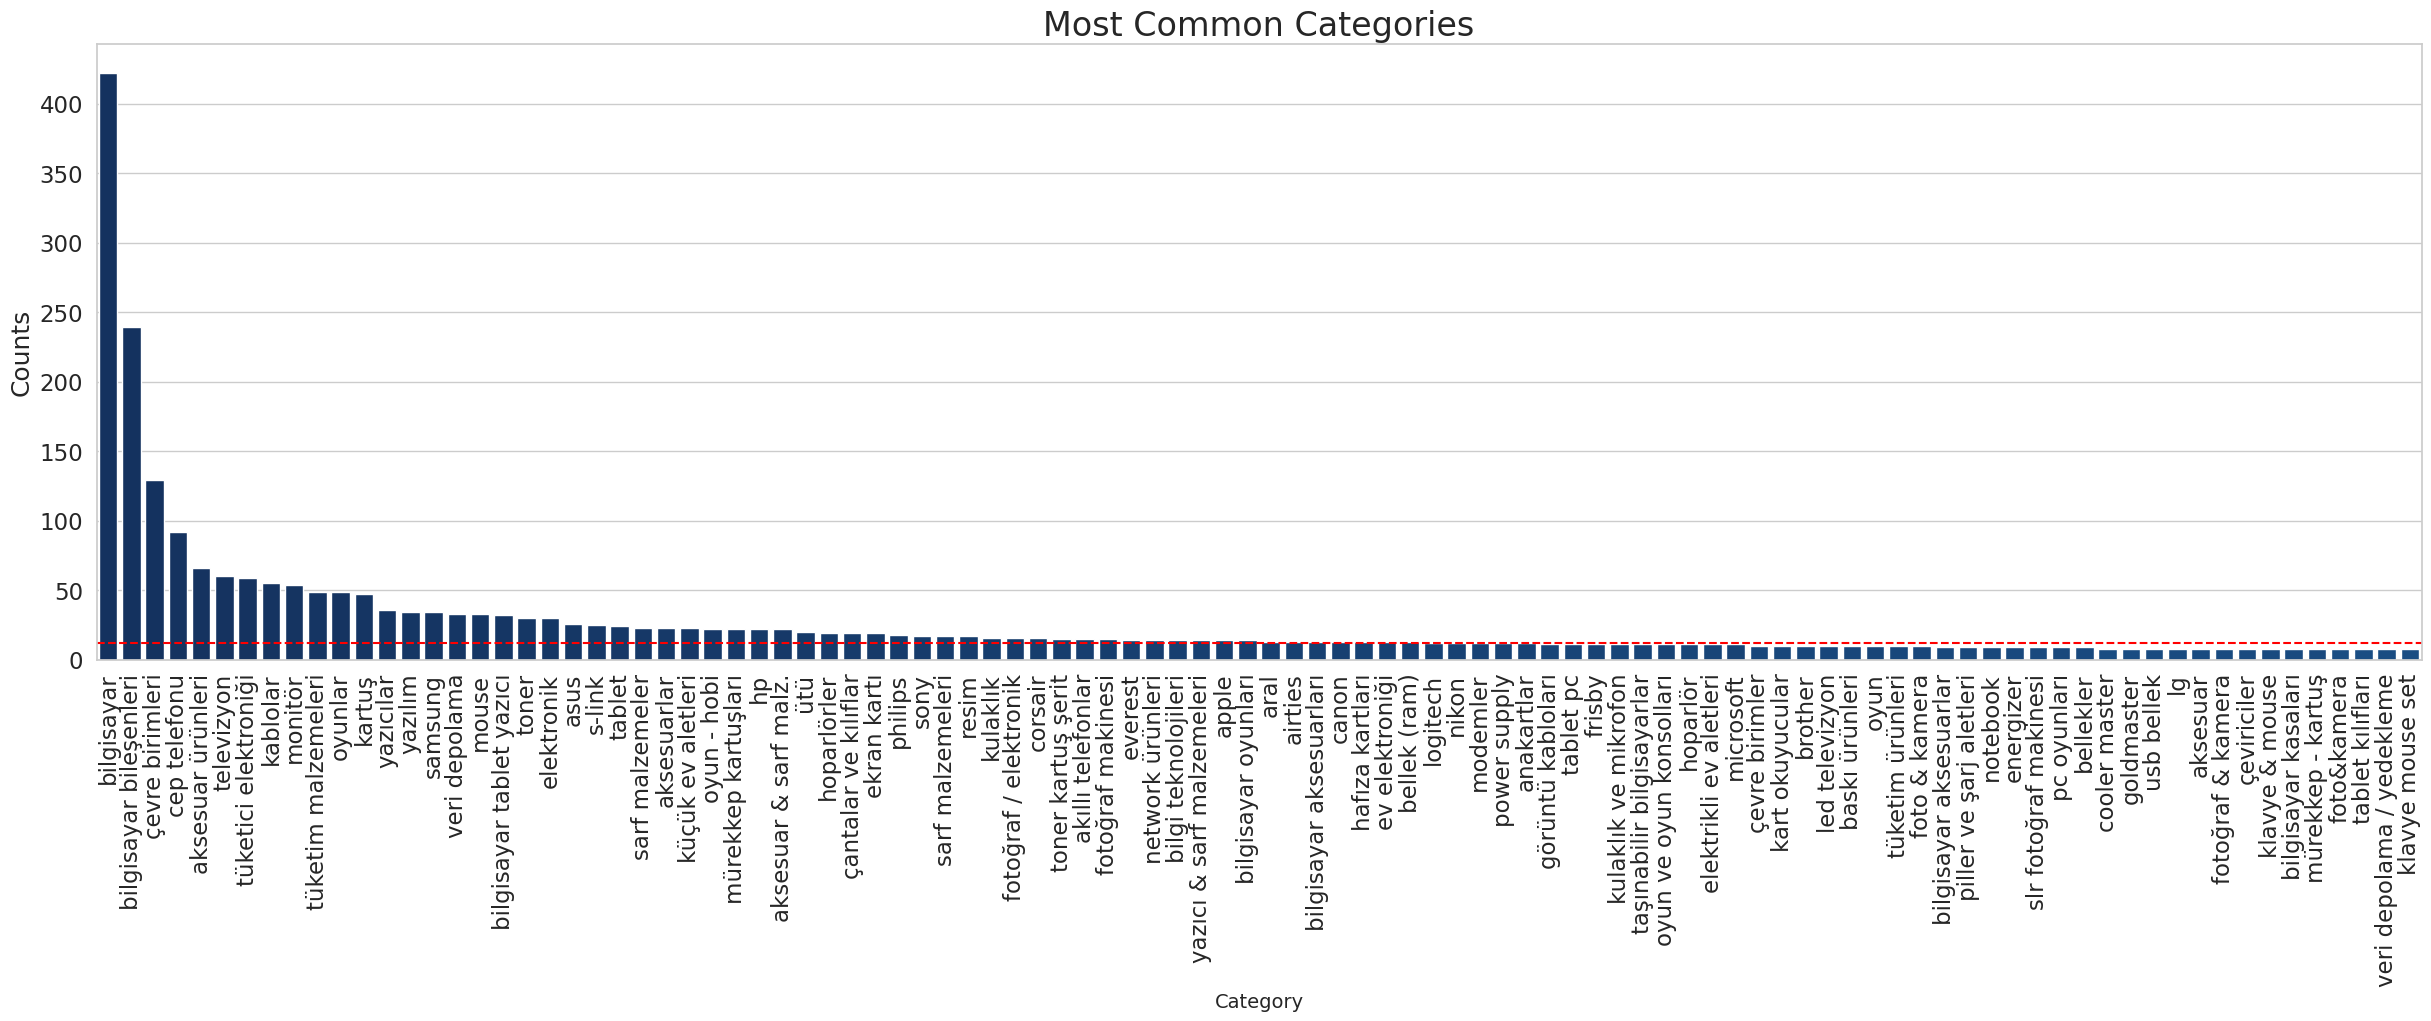

In [96]:
threshold = 12  # Trashold value

plt.figure(figsize=(30, 8))
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

pal = sns.color_palette("Blues_r", len(bar_plot))
rank = bar_plot['count'].argsort().argsort()

sns.barplot(x=bar_plot['category'][:100], y=bar_plot['count'][:100], palette=np.array(pal[::-1])[rank])
plt.axhline(threshold, ls='--', c='red')
plt.title("Most Common Categories", fontsize=24)
plt.ylabel('Counts', fontsize=18)
plt.xlabel('Category', fontsize=14)
plt.xticks(rotation='vertical')
plt.show()


I want to chose trashold value as 12, because the categories with lower than 12 is very sprecific categories. Therefore, we can ignore them.

In [97]:
threshold = 12 

warnings.filterwarnings('ignore')

main_categories = pd.DataFrame()
main_categories = bar_plot[bar_plot['count']>threshold]
categories = main_categories['category'].values
categories = np.append(categories,'Others')
not_category = []
df2['Others'] = 0

for i in df2.columns[2:]:
    if i not in categories:
        df2['Others'][df2[i] == 1] = 1
        not_category.append(i)

df2.drop(not_category, axis=1, inplace=True)

df2.shape

(1482, 60)

We decrease the number of classes from 930 to 60. 

In [106]:
category_count = ['Category 0', 'Category 1', 'Category 2', 'Category 3','Category 4']
num_products = [0, 0, 0, 0,0,0,0, 0,0,0,0]

for i in range(len(categories)):
    print((categories[i]))
    num_products[len(categories[i])] += 1

bilgisayar
bilgisayar bileşenleri


IndexError: list index out of range

## Data Cleaning

### Remove Stop Words for Turkish

Let's create a funciton for removing stop words. Since our descriptions are Turkish, I use different library that finds Turkish stop words. 

Main source of list is: https://github.com/sgsinclair/trombone/blob/master/src/main/resources/org/voyanttools/trombone/keywords/stop.tr.turkish-lucene.txt

In [5]:
import trstop

def removeStopWords(sentence):
    words = sentence.split(" ")
    for word in words:
        if trstop.is_stop_word(word):
            words.remove(word)
    return " ".join(words)

In [38]:
text = ["Mahkemenin","bu","kararında", "kadına","yönelik","şiddetin",
"toplumda","oluşturduğu","rahatsızlığın", "etkili","olduğu", "bilgisayarı"]

textt = "Merhabalar ben Alperen Ovak, Kendimi geliştirmeyi ve yeni şeyler öğrenmeyi severim"

text_zeyrek = []

In [43]:
from zeyrek import MorphAnalyzer
import nltk #bu ve bunun altındaki satırı punkt kütüphaneniz yüklü ise kapatabilirsiniz.
#nltk.download("punkt")

def stemming(sentence):
    zeyrek = MorphAnalyzer()
    result = []
    words = sentence.split(" ")
    result = []
    for index in range(len(words)):
        result.append(zeyrek.lemmatize(words[index])[0][1][0])

    return result
    

In [44]:
stemming(textt)

APPENDING RESULT: <(merhaba_Noun)(-)(merhaba:noun_S + lar:a3pl_S + pnon_S + nom_ST)>
APPENDING RESULT: <(merhaba_Noun)(-)(merhaba:noun_S + a3sg_S + pnon_S + nom_ST + nounZeroDeriv_S + nVerb_S + nPresent_S + lar:nA3pl_ST)>
APPENDING RESULT: <(ben_Noun)(-)(ben:noun_S + a3sg_S + pnon_S + nom_ST)>
APPENDING RESULT: <(ben_Pron_Pers)(-)(ben:pronPers_S + pA1sg_S + pPnon_S + pNom_ST)>
APPENDING RESULT: <(alperen_Noun)(-)(alperen:noun_S + a3sg_S + pnon_S + nom_ST)>
APPENDING RESULT: <(,_Punc)(-)(,:puncRoot_ST)>
APPENDING RESULT: <(kendi_Pron_Reflex)(-)(kendi:pronReflex_S + pReflexA1sg_S + m:pP1sg_S + i:pAcc_ST)>
APPENDING RESULT: <(geliştirmek_Verb)(-)(geliştir:verbRoot_S + me:vInf2_S + noun_S + a3sg_S + pnon_S + yi:acc_ST)>
APPENDING RESULT: <(gelişmek_Verb)(-)(geliş:verbRoot_S + tir:vCausTır_S + verbRoot_S + me:vInf2_S + noun_S + a3sg_S + pnon_S + yi:acc_ST)>
APPENDING RESULT: <(ve_Conj)(-)(ve:conjRoot_ST)>
APPENDING RESULT: <(yeni_Adj)(-)(yeni:adjectiveRoot_ST)>
APPENDING RESULT: <(yeni_Adv)

['merhaba',
 'ben',
 'alperen',
 'Ovak',
 'kendi',
 'gelişmek',
 've',
 'yen',
 'şey',
 'öğrenmek',
 'sever']

## Model Training

In [107]:

X_train, X_test, y_train, y_test = train_test_split(df2['description'], 
                                                    df2[df2.columns[2:-1]], 
                                                    test_size=0.3, 
                                                    random_state=0, 
                                                    shuffle=True)

In [108]:
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2') # Using a tf-idf weighting scheme rather than normal boolean weights for better performance
vectorizer.fit(X_train) # Reference : https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [109]:
print("X_train shape : ",X_train.shape)
print("X_test shape : ",X_test.shape)

X_train shape :  (1037, 214461)
X_test shape :  (445, 214461)


In [110]:
LR_pipeline = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1))]) 
# one-vs-all, this strategy consists in fitting one classifier per class. For each classifier, the class is fitted against all the other classes. In addition to its computational efficiency (only n_classes classifiers are needed), one advantage of this approach is its interpretability. Since each class is represented by one and one classifier only, it is possible to gain knowledge about the class by inspecting its corresponding classifier. This is the most commonly used strategy for multiclass classification and is a fair default choice.
# Reference : https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html

# sag : Algorithm to use in the optimization problem, "saga’ also supports "elasticnet’ penalty  Reference : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
# n_jobs : The number of jobs to use for the computation: the n_classes one-vs-rest problems are computed in parallel. Reference : https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html
# clf : name given to the Pipeline

accuracy = 0
auc = 0
modelNumber = 1
for category in df2.columns[2:-1]:    
    LR_pipeline.fit(X_train, y_train[category]) # Training logistic regression model on train data
    prediction = LR_pipeline.predict(X_test)    # calculating predictions
    acc = accuracy_score(y_test[category], prediction)
    au = roc_auc_score(y_test[category],prediction)
    accuracy = accuracy + acc
    auc = auc + au
    print('CATEGORY => {} '.format(category),'AUC ROC score => {}'.format(au)," Accuracy => {}".format(acc))
    filename = str(modelNumber)+"_model.sav"
    joblib.dump(LR_pipeline, filename)          # saving individual classifiers for later use
    modelNumber += 1
print("-------------------------------------------------------------------------------------------------------------------------------")
print('Test averaged Accuracy => {}'.format(accuracy/len(df2.columns[2:-1])))
print('Test averaged AUC ROC Score => {}'.format(auc/len(df2.columns[2:-1])))

CATEGORY => bilgisayar  AUC ROC score => 0.6161875  Accuracy => 0.7775280898876404
CATEGORY => cep telefonu  AUC ROC score => 0.5  Accuracy => 0.9258426966292135
CATEGORY => ev elektroniği  AUC ROC score => 0.5  Accuracy => 0.9932584269662922
CATEGORY => bilgisayar bileşenleri  AUC ROC score => 0.5  Accuracy => 0.8449438202247191
CATEGORY => fotoğraf / elektronik  AUC ROC score => 0.5  Accuracy => 0.9955056179775281
CATEGORY => küçük ev aletleri  AUC ROC score => 0.5  Accuracy => 0.9797752808988764
CATEGORY => televizyon  AUC ROC score => 0.5  Accuracy => 0.9617977528089887
CATEGORY => monitör  AUC ROC score => 0.5  Accuracy => 0.9640449438202248
CATEGORY => çevre birimleri  AUC ROC score => 0.5  Accuracy => 0.9168539325842696
CATEGORY => network ürünleri  AUC ROC score => 0.5  Accuracy => 0.9932584269662922
CATEGORY => tüketici elektroniği  AUC ROC score => 0.5  Accuracy => 0.9483146067415731
CATEGORY => yazılım  AUC ROC score => 0.5  Accuracy => 0.9730337078651685
CATEGORY => bilgi t

As you can see above, when we imply binary classificaiton for each class by using *he one-vs-rest method* we got total 0.97 accuracy. 